# Interaktivní INTRO k Fouriérově transformaci (FT)
  * Nepůjdu do žádné složité matematiky.
  * Ale pokusím se představit proč je FT tak užitečný koncept.
  
1. Každá rozumná periodická (kmitající) funkce se dá vyjádřit Fourierovskou řadou, která obsahuje jen funkce sinus a cosinus.
2. Navíc, každá funkce se dá Fourierovsky transformovat, což znamené rozložit do frekvenčních komponent.
3. Problém je, že Fourierovská řada může být nekonečná.
4. Naštěstí jsou její členy uspořádány podle klesající důležitosti. To znamená, že vždy bereme ty nejdůležitějsí jako první.
5. Ostatní členy jsou korekce k funkci (řadě), kterou již máme.
6. Důležité je, že pokud mám oscilující funkci, FT mi vrací informaci o frekvencích (mnoha sinusů sečtených domhromady), které mi popisují moje šíleně vypadající oscilace.

## Kde se FT používá?
1. Komprese (obrázků, hudby atd.)
2. Odstraňování šumu
3. Analýza signálu (frekvence zvuku, světelných vln, tedy barev atd.) 

In [1]:
## Potřeba jen pokuď používáš Google colabs
import subprocess
import sys

def install_module(module):
    subprocess.call([sys.executable, "-m", "pip", "install", module])
    
install_module('dash')
install_module('jupyter_dash')

In [1]:
# vědecké moduly
import numpy as np
from scipy import signal, fft

# import modulů pro interaktivní grafiku
from dash import Dash, html, dcc, Input, Output
from jupyter_dash import JupyterDash
import plotly.express as px
import plotly.graph_objects as go

# standartní vykreslování
import matplotlib.pyplot as plt
from matplotlib import cm

plt.rcParams['figure.facecolor'] = 'white'

### Vytvořme obdelníkový signál spolu s jednoduchým sinusem.

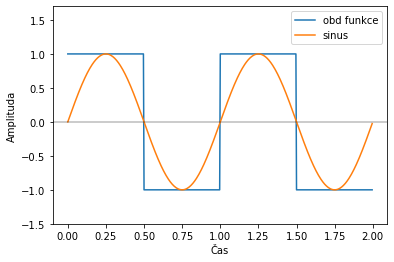

In [2]:
# naši osu x, abych naznačil kmitání v čase, nazvu t
t = np.linspace(0, 2, 500, endpoint=False)

# obdelníková funkce je známá, proto ji najdeme v modulu "signal"
plt.plot(t, signal.square(2 * np.pi * t), label='obd funkce')
plt.plot(t, np.sin(2*np.pi*t), label='sinus')
plt.axhline(0, color='k', lw=0.4)
plt.ylim(-1.5, 1.7)
plt.xlabel('Čas')
plt.ylabel('Amplituda')
plt.legend(loc='upper right')
plt.show()

Obdelníková funkce kmitá, což je dobře, ale jak do prkený vohrady dokážeme popsat její ostré rohy jen s pomocí sinů a cosinů?

---

Výpočet na papíře je na úrovni vysoké školy, takže my si jen půjčíme výsledek z wikipedie (pokud chceš více podrobností, koukni na vysvětlení zde [Wolfram explanation](https://mathworld.wolfram.com/FourierSeriesSquareWave.html)

\begin{align}
F(t)=\dfrac{4}{\pi}\sum_{k=1}^{\infty}{\dfrac{\sin{(2\pi(2k-1)ft)}}{2k-1}} = {\color{red}\dfrac{4}{\pi}}\left(\sin{({\color{green}\omega} t)} + {\color{red}\dfrac{1}{3}}\sin{({\color{green}3\omega} t)} + {\color{red}\dfrac{1}{5}}\sin{({\color{green}5\omega} t)} + ...\right)
\end{align}
, pro $\omega=2\pi ft$.

### Co to znamená?
Pokuď se podíváš na pravou stranu vzorečku, vidíš, že sčítáme vyšší a vyšší frekvence (násobíme $\omega$ většími konstantami), ale zároveň amplitudy (konstanty před siny) se zmenšují, tedy jsou stále méně a méně podstatné.

Toto řazení členů Fourierovské řady je užitečné, proto nám zajišťuje, že jakýkoli počet členů vezmemme, budou to ty nejdůležitější. Další následují členy mi výsledek vylepší, ale čím dál méně.

### Důležité
Po tom co FT provedeme, budeme vykreslovat frekvence na ose x (zelené členy) a jejich příslušné amplitudy na ose y (červená čísla).

In [3]:
## fourierovská řada
def ft_rada_obd(x_osa, frek, n_frek):
    # nejdřív vytvořme pole nul, kam budeme přidávat členy sinusů
    f_hodnoty = np.zeros(len(x_osa))
    
    # k je k ze vzorce nahoře
    for k in range(1, n_frek + 1):
        # pro vyšší a vyšší frekvence, přidávám kmitající siny do již existujícího pole
        f_hodnoty = f_hodnoty + np.sin(2*np.pi * (2*k-1) * frek * x_osa)/(2*k-1)

    # nakonec vynásob první konstantou, místo násobení v každé iteraci 
    return f_hodnoty * 4/np.pi

## FFT znamené "fast fourier transform", standardní a rychlý algoritmus pro výpočet FT
# pokud má osa x rovnoměrně odstupňované (ekvidistantní) hodnoty
def proved_fft(x, f):
    # vlastně je to jen toto, v pythonu extrémně jednoduché
    f_fft = fft.fft(f)

    # navíc ale musíme spočíst správnou osu x (frekvence), a proto musíme znát takzvaný krok
    t_step = abs(x[1] - x[0])  # velikost časového kroku 
    
    # FT amplitudy jsou symetrické, takže můžeme vzít je polovinu intervalu (viz hranatá závorka)
    x_fft = fft.fftfreq(len(x), t_step)[:len(x) // 2]

    return x_fft, 2.0/len(x) * np.abs(f_fft[0:len(x)//2])

## Následující část je definice interaktvního grafického zobrazení
  * Vypadá komplikovaně, klidně přeskočte. Ukazuji to zde protože:
  * Tyto grafy jsou vnořeny do elementů html, takže mohou být zakomponovány do jakékoli webové stránky.
  * A někdo vás za to může najmout.
  
### Nakonec ale neděláme nic jiného, než počítaní FT jako výše. 

1. FT spektrum (tj amplitudy frekvencí) vpravo, frekvence na ose x, amplitudy na ose y PRO KAŽDOU vlnu sinusu.
2. Vlevo je pak součet všech vln sinus z pravého grafu, a jak se přibližuje obdelníkové funkci.

In [4]:
app = JupyterDash(__name__)
# cokoli začíná html. značí elementy jazyka html
# které mají jistý "style" definovaný v CSS jazyce, proto se většinou
# učí html a CSS dohromady.
app.layout = html.Div([
    html.H1('Jak funguje FFT.'),
    
    html.Div([
        html.Div([
            # levý graf v samostatném div elementu
            dcc.Graph(id='casova_domena')
        ], style={'width':'49%', 'display': 'inline-block'}),
    html.Div([
        # pravý graf v samostatném div
        dcc.Graph(id='frekvencni_domena')
    ], style={'width': '49%', 'display': 'inline-block'}),
    
    # titulek velikosti 4
    html.H4('Počet frekvencí'),
    # div elementu posuvu, kterým vybíráme počet frekvencí
    html.Div(dcc.Slider(
        1, 20, step=1,
        id='n_frek_slider',
        value=1
    ), style={'width': '100%', 'display': 'inline-block'}),
], style={'width': '100%', 'display': 'inline-block'}),
    
    
], style={'backgroundColor':'white'})

# obnov levý graf, když pohnu posuvníkem
@app.callback(
    Output('casova_domena', 'figure'),
    Input('n_frek_slider', 'value'))

def obnov_graf(n_frek):
    # obdelníková funkce
    t = np.linspace(0, 2, 500, endpoint=False)
    f = ft_rada_obd(t, 1, n_frek)

    # prvotní graf Fourierovské řady (jen sinus)
    fig = go.Figure()
    fig.add_trace(
        go.Line(
            x=t,
            y=f,
            name='FT sin řada'),
        )

    # přidej obdelníkovou funkci do grafu
    fig.add_trace(
        go.Line(
            x=t,
            y=signal.square(2 * np.pi * t),
            name='Obdelníková vlna'),
        )
    # definuj popisky grafu
    fig.update_layout(
        yaxis_range=[-1.5,1.5],
        xaxis_title="Čas",
        yaxis_title="Amplituda",
        )
    # legenda
    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=1.2,
            xanchor="left",
            x=0.01),
        )
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        )
    return fig

# obnov pravý graf, když pohnu posuvníkem
@app.callback(
    Output('frekvencni_domena', 'figure'),
    Input('n_frek_slider', 'value'))

def fft_funkce(n_frek):
    # spočti FT pomocí proved_fft() funkce
    t = np.linspace(0, 2, 500, endpoint=False)
    x, y = proved_fft(t, ft_rada_obd(t, 1, n_frek))

    fig = go.Figure()  # definuj obrázek
    # přidej graf
    fig.add_trace(go.Line(
                    x=x,
                    y=y),
                )
    # vlastnosti obrázku, limity os, okraje (margin), a popisky os (labels)
    fig.update_layout(xaxis_range=[0,42])
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        xaxis_title="Frekvence [1/Čas]",
        yaxis_title="Amplituda",
        )
    return fig

In [5]:
del app.config._read_only["requests_pathname_prefix"]

In [6]:
app.run_server(mode='inline')

c:\Users\David Palecek\Documents\Python_projects\pymarad\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Dobrá práce, teď je čas se mrknout na použití FT:
1. Komprese obrázku
2. Vytváření nového hudebního nástroje